In [2]:
#add date
#add to csv
#start zillow
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
import time
import pandas as pd
import re
import seaborn as sb

In [3]:
url = 'https://www.airbnb.com/s/Dallas--TX--USA/homes?place_id=ChIJS5dFe_cZTIYRj2dH9qSb7Lk&refinement_paths%5B%5D=%2Fhomes&checkin=2022-08-28&checkout=2022-08-29&date_picker_type=calendar&adults=10&search_type=AUTOSUGGEST&tab_id=home_tab&query=Dallas%2C%20TX%2C%20USA&flexible_trip_lengths%5B%5D=one_week&federated_search_session_id=ac780de5-b1ff-48b8-a9e8-2b2e88e6fd55&pagination_search=true'
State = 'Texas'
allplaces = []
page_count = 0
options = Options()
options.add_argument('--blink-settings=imagesEnabled=false')
driver = webdriver.Chrome(options=options,executable_path='./chromedriver')
driver.set_window_position(0, 0)
driver.set_window_size(2560, 1440)


/var/folders/lw/r6bk51ln09vdlk9nc13qh7280000gn/T/ipykernel_18830/527381162.py:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(options=options,executable_path='./chromedriver')


In [5]:
listings = []

next_page = url

while next_page:
    flag = True
    driver.get(next_page)
    time.sleep(7)

    links = driver.find_elements(By.TAG_NAME,'a')
    for l in links:
        if l.get_attribute('href').find('https://www.airbnb.com/rooms') > -1:
            listings.append(l.get_attribute('href'))
        elif l.get_attribute('aria-label') == 'Next':
            next_page = l.get_attribute('href')
            flag = False
    
    if flag:
        next_page = ''

listings = pd.Series(listings)
listings.drop_duplicates(inplace=True)


places = []
for l in listings:
    driver.get(l)

    
    def site_loaded(d):
            try:
                alltext = ''
                divs = d.find_elements(By.TAG_NAME,'div')
                for div in divs:
                    alltext = alltext + div.text
                return True
            except:
                return False

    WebDriverWait(driver,timeout=20).until(site_loaded)

    alltext = ''
    divs = driver.find_elements(By.TAG_NAME,'div')
    for div in divs:
        alltext = alltext + div.text


    a = {
    'title':driver.find_element(By.CLASS_NAME,'_fecoyn4').text,
    'guests':int(re.search('\d+(?= guest)',alltext).group()),
    'bedrooms':0,
    'beds':0,
    'bathrooms':0,
    'price':int(re.search('(?<=\$)\d+',alltext).group()),
    'days booked':0,
    'Superhost':alltext.find('Superhost') > -1,
    'location':'',
    'rating':0,
    'reviews':0,
    'place type':re.search('[\w ]+(?= hosted)',alltext).group(),
    'State':State
    }
    try:
        a['location'] = re.search(f'[\w ]+(?=, {State})',alltext).group()
    except:
        a['location'] = re.search('[\w ]+(?=, United States)',alltext).group()
    try:
        a['beds'] = int(re.search('\d+(?= beds)',alltext).group())
    except:
        a['beds'] = 0
    try:
        a['bedrooms'] = int(re.search('\d+(?= bedroom)',alltext).group())
    except:
        a['bedrooms'] = 0

    try:
        a['bathrooms'] = int(re.search('[\d,.]+(?= bath)',alltext).group())
    except:
        if re.search('\d+(?= shared)',alltext):
            a['bathrooms'] = int(re.search('\d+(?= shared)',alltext).group())
    try:
        a['rating'] = float(re.search('\d.\d+',alltext).group())
    except:
        print('no rating')

    try:
        a['reviews'] = int(re.search('\d+(?= review)',alltext).group())
    except:
        print('no reviews')


    cal = driver.find_elements(By.TAG_NAME,'td')

    for d in cal:
        if d.get_attribute('aria-label'):
            if d.get_attribute('aria-label').find('Unavailable') > -1:
                a['days booked'] += 1


    for i in range(2):
        buttons = driver.find_elements(By.TAG_NAME,'button')

        for b in buttons:
            if b.get_attribute('aria-label'):
                if b.get_attribute('aria-label').find('next month') > -1:
                    b.click()
                    time.sleep(1)
                    cal = driver.find_elements(By.TAG_NAME,'td')
                    for d in cal:
                        if d.get_attribute('aria-label'):
                            if d.get_attribute('aria-label').find('Unavailable') > -1:
                                a['days booked'] += 1

    places.append(a)








no rating
no rating
no rating
no rating
no reviews
no reviews
no rating
no reviews
no reviews
no reviews
no rating
no reviews
no rating
no reviews
no rating
no reviews


In [14]:
driver.quit()

In [6]:
len(listings)

163

In [7]:
len(places)

163

In [10]:
df = pd.DataFrame(places)

In [9]:
df.head()

,title,guests,bedrooms,beds,bathrooms,price,days booked,Superhost,location,rating,reviews,place type,State
0,"Hot Tub, Putting Green, Game Room!",10,3,4,2,237,51,True,Carrollton,5.00,28,Entire home,Texas
1,Cheerful 4 bedrooms vacation home near Bishop ...,12,4,6,2,285,32,True,Dallas,5.00,4,Entire home,Texas
2,★Amazing Backyard★ 5min walk to Restaurants,10,3,5,2,192,155,False,Dallas,4.77,186,Entire home,Texas
3,Stylish & Comfy ~ Mins to AT&T ~ ♛Royal Beds ~...,12,5,6,0,250,90,False,Grand Prairie,5.00,6,Entire home,Texas
4,"Cozy 2 story house, 5 bedrooms, 8 beds",12,5,8,0,339,3,False,Frisco,4.90,10,Entire home,Texas


In [11]:
df.to_csv('airbnb.csv')

/Users/asadsabir/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='guests', ylabel='price'>

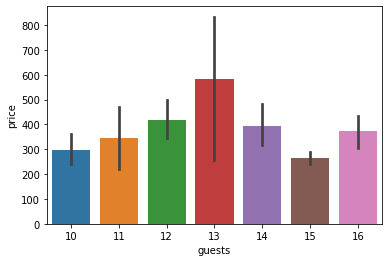

In [13]:
sb.barplot(df['guests'],df['price'])